In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import numpy as np
import pandas as pd

def load_dataset(base_dir, target_len=300):
    X, y = [], []
    for label, category in enumerate(["legit", "cheater"]):
        path = os.path.join(base_dir, category)
        for file in os.listdir(path):
            if file.endswith('.csv'):
                file_path = os.path.join(path, file)
                try:
                    df = pd.read_csv(file_path)
                    features = df.drop(columns=['tick', 'steamid', 'label'], errors='ignore')

                    if features.shape[0] >= 290:  # allow slightly short segments
                        # Pad at the end if shorter than 300
                        if features.shape[0] < target_len:
                            pad_rows = target_len - features.shape[0]
                            last_row = features.iloc[-1:]
                            padding = pd.concat([last_row] * pad_rows, ignore_index=True)
                            features = pd.concat([features, padding], ignore_index=True)

                        X.append(features.values[:target_len])  # trim if over
                        y.append(label)

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    return np.array(X), np.array(y)


X, y = load_dataset("/content/drive/MyDrive/Skripsi/data/processed/features")
print(X.shape, y.shape)


(104, 300, 20) (104,)


Normalization

In [20]:
from sklearn.preprocessing import StandardScaler

# Flatten for fitting
X_flat = X.reshape(-1, X.shape[-1])

# Fit scaler on all data (or just training later)
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)

# Reshape back
X_scaled = X_scaled_flat.reshape(X.shape)


Train Test Val Split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (72, 300, 20)
Val:   (16, 300, 20)
Test:  (16, 300, 20)


In [26]:
import numpy as np
counts = np.bincount(y)  # y is your label array where 0=legit, 1=cheat
print(f"Legit: {counts[0]}, Cheat: {counts[1]}")

Legit: 67, Cheat: 37


LSTM Model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(300, 20)),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300, 64)        │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,721 (135.63 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 0 (0.00 B)

Training

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.6731 - loss: 0.6475 - val_accuracy: 0.8125 - val_loss: 0.5399
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.7480 - loss: 0.5441 - val_accuracy: 0.8125 - val_loss: 0.4275
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.8160 - loss: 0.4177 - val_accuracy: 0.8125 - val_loss: 0.3514
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.8025 - loss: 0.4154 - val_accuracy: 1.0000 - val_loss: 0.2874
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.8189 - loss: 0.3414 - val_accuracy: 1.0000 - val_loss: 0.2250
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.9402 - loss: 0.2386 - val_accuracy: 0.7500 - val_loss: 0.9049
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.8682 - loss: 0.4771 - val_accuracy: 1.0000 - val_loss: 0.1807
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.9929 - loss: 0.1432 - val_accuracy: 1.0000 - val_loss:

In [24]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.75      0.60      0.67         5

    accuracy                           0.81        16
   macro avg       0.79      0.75      0.77        16
weighted avg       0.81      0.81      0.81        16



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


<Figure size 400x400 with 0 Axes>

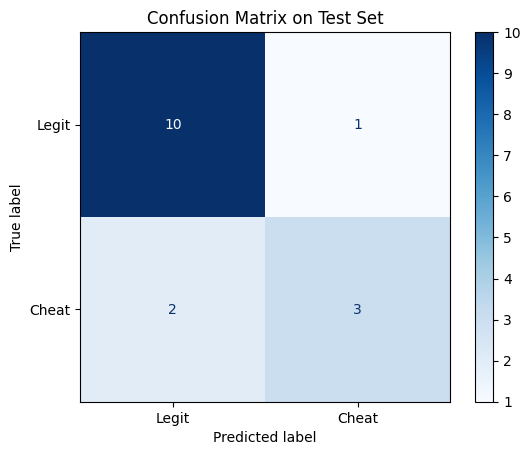

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Legit","Cheat"])

# Plot
plt.figure(figsize=(4,4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()


In [16]:
path = "/content/drive/MyDrive/Skripsi/data/processed/features/legit"

for file in os.listdir(path):
    if file.endswith('.csv'):
        file_path = os.path.join(path, file)
        try:
            df = pd.read_csv(file_path)
            print(f"{file} → {df.shape[0]} rows")
        except Exception as e:
            print(f"Failed to read {file}: {e}")

engineered_Copy of cheater(xxx)_kill_31433_to_31733.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_32036_to_32336.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_55282_to_55582.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_18998_to_19298.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_19243_to_19543.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_11928_to_12228.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_30932_to_31232.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_39940_to_40240.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_5008_to_5308.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_19477_to_19777.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_9322_to_9622.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_13254_to_13554.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_35960_to_36260.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_27305_to_27605.csv → 297 rows
engineered_Copy of cheater(xxx)_kill_7398_to_7698.csv → 297 rows
e